![](https://media.giphy.com/media/64aBXTVfd90zyUH2da/giphy.gif)


In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


## Preparing the Data

In [2]:
X=[]
Z=[]

X1 = []
Z1 = []
IMG_SIZE=64
NORMAL_TEST_DIR='../../../../mlwithpatu/chest_xray/test/NORMAL'
PNEUMONIA_TEST_DIR='../../../../mlwithpatu/chest_xray/test/PNEUMONIA'

NORMAL_TRAIN_DIR='../../../../mlwithpatu/chest_xray/train/NORMAL'
PNEUMONIA_TRAIN_DIR='../../../../mlwithpatu/chest_xray/train/PNEUMONIA'


In [3]:
def assign_label(img,disease_type):
    return disease_type

In [4]:
def make_train_data(disease_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,disease_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

        
        

In [5]:
def make_test_data(disease_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,disease_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X1.append(np.array(img))
        Z1.append(str(label))

        

In [6]:
make_test_data('Normal',NORMAL_TEST_DIR)
print(len(X1))

100%|██████████| 234/234 [00:06<00:00, 38.58it/s]

234


In [7]:
make_test_data('Pneumonia',PNEUMONIA_TEST_DIR)
print(len(X1))

100%|██████████| 390/390 [00:05<00:00, 77.62it/s]

624


In [8]:
make_train_data('Normal_train',NORMAL_TRAIN_DIR)
print(len(X))

100%|██████████| 1341/1341 [00:49<00:00, 27.13it/s]

1341


In [9]:
make_train_data('Pneumonia_train',PNEUMONIA_TRAIN_DIR)
print(len(X))

100%|██████████| 3875/3875 [00:44<00:00, 86.87it/s] 

5216


## Visualizing some Random Images on the Train List

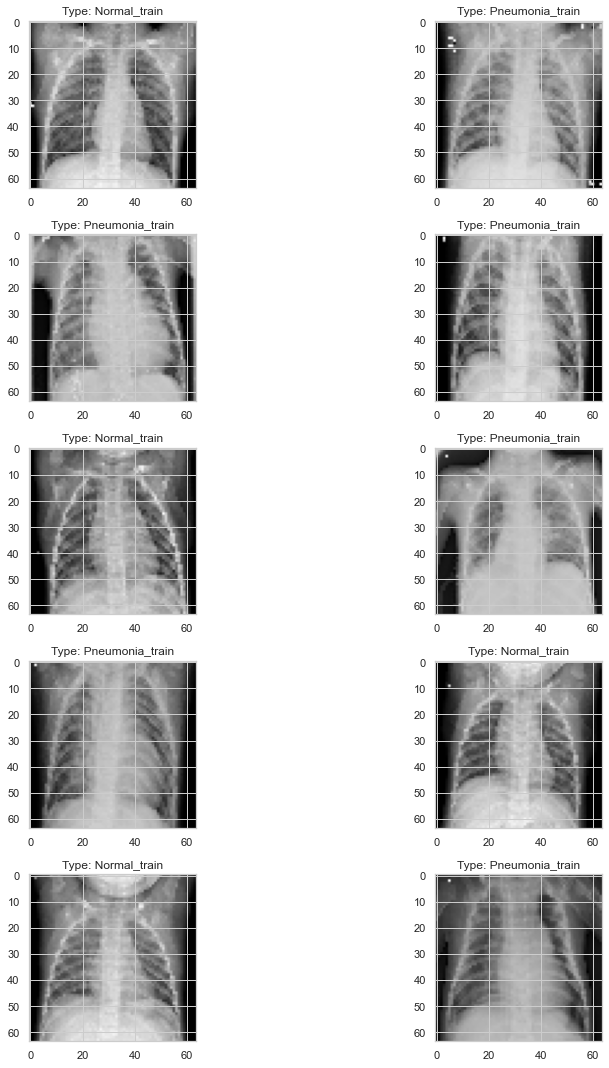

In [10]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Type: '+Z[l])
        
plt.tight_layout()

## Label Encoding the Y array & then One Hot Encoding 

In [11]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
X=np.array(X)
X=X/255

In [12]:
le=LabelEncoder()
Y1=le.fit_transform(Z1)
Y1=to_categorical(Y1,2)
X1=np.array(X1)
X1=X1/255

##  Giving better names for the arrays. (This part was for splitting the data before. But we split the data in the dataset level as best practice)

In [13]:
x_train = X## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding 
y_train = Y
x_test = X1
y_test = Y1


## Setting the random seeds

In [14]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## Specifying the Base Model

We used VGG16 mode as the base mode. With the input shape of 64,64,3

In [15]:
base_model=VGG16(include_top=False, weights=None,input_shape=(64,64,3), pooling='avg')


In [16]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

Adding our model, making it trainable and adding last layers.

In [17]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2,activation='softmax'))

for layer in base_model.layers:
    layer.trainable=True


Using datagen to add random rotations, zooms, shifts and flips to the train dataset

In [18]:
datagen = ImageDataGenerator() 
datagen.fit(x_train)

In [19]:
epochs=10
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 14,847,554
Trainable params: 14,847,042
Non-trainable params: 512
_________________________________________________________________


In [21]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size, shuffle=True),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/10
38/40 [===========================>..] - ETA: 28s - loss: 0.4407 - accuracy: 0.8111

Training the model. In the plots under, we can see how the accuracy and loss values changed over epochs.

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i][0])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [ ]:
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Diagnosis : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Diagnosis : "+str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

In [ ]:
warnings.filterwarnings('always')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Diagnosis : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Diagnosis : "+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1